In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import random
import pandas as pd
from sklearn.linear_model import LinearRegression
import heapq
import string
pynt=False
if pynt:
    import pynt
    pynt.set_style('pynt')
    pynt.set_fontsize(12)

# Global variables
operations=np.array(["[0]NOT", "[1]NAND", "[2]AND", "[3]ORN", "[4]OR", "[5]ANDN", "[6]NOR", "[7]XOR", "[8]EQU"])

## Instructions
- Data from avida run saves automatically in "./cbuild/work/data/AGIdata/run". It consists of three csv files and a folder: "settings.csv", "metarun.csv" and "chromosomes.csv". The latter is only used for the run itself. The folder is called "meta" and it itself consists of folders "M0", "M1", "M2" and so on. These in turn consist of csv files with names "N0.csv", "N1.csv", "N2.csv" and so on. These contain data for the updates for every world. 
- If you want to save the "run" folder change the name to something so it won't be overwritten. The following functions uses the "run" folder per default but pass another name in the variable "run_name" to change this.


### General functions
- read_settings_data

### Meta evolution analysis
- read_meta_data
- plot_meta_data
- plot_chromosome_convergence
- plot_final_genome
- plot_edit_distances
- decay
- produce_meta_report

### Avida performance analysis
- read_update_data
- plot_update_data
- compare_meta_runs
- plot_strategy_data
- compare_strategies

### Controller evaluation
- phi_c and alignment: controller fitness
- compute_strategy_probability
- compute_strategy_fitness
- filter_best_strategies
- plot_strategy_evaluation
- generate_regression_data
- produce_strategy_evaluation
- read_fas3_data
- get_instruction_set
- create_useful_alignment_data
- good_AGI
- plot_good_agi



In [2]:
def read_settings_data(run_name="run"):
    df = pd.read_csv(f"./{run_name}/settings.csv")
    return df

In [3]:
def read_meta_data(run_name="run"):

    data = np.genfromtxt(f"./{run_name}/metarun.csv", delimiter=',', skip_header=1)
    m=data[:,0]
    phi_0_max=data[:,1]
    imax=data[:,2]
    chromosome_length = data.shape[1]-3

    hat_phi = np.array([data[:,i] for i in range(3,3+chromosome_length)])
    meta_data = {"m":m, "phi_0_max":phi_0_max, "imax": imax, "chromosome":hat_phi, "chromosome_length":chromosome_length}
    return meta_data

In [4]:
def plot_meta_data(ax, flag=0, task=0, run_name="run"):
    data = read_meta_data(run_name=run_name)
    if flag==0:
        ax.plot(data['m'], data['phi_0_max'])
        ax.set(xlabel='Meta Generation', ylabel=r"Max controller fitness", yscale='log')
    if flag==1:
        ax.plot(data['m'], data['chromosome'][task])
        ax.set(ylabel="Gene value", xlabel=r'$m$')

In [5]:
def plot_chromosome_convergence(ax, run_name="run"):

    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    distances = np.empty(chromosomes.shape[1]-1)
    for i in range(chromosomes.shape[1]-1):
        chromosome1 = chromosomes[:,i]
        chromosome2 = chromosomes[:,i+1]

        dist = 0
        for j in range(chromosomes.shape[0]):
            dist += np.abs(chromosome1[j] - chromosome2[j])
        
        distances[i] = dist

    ax.plot(distances)
    ax.set(xlabel="m", ylabel="$|X_{i+1} - X_i|$", title="Chromosome convergence")




In [6]:
def plot_final_genome(ax, run_name="run", inst_set=False):
    data = read_meta_data(run_name=run_name)
    final_chromosome = np.array([d[-1] for d in data['chromosome']])
    chromosome_length = len(final_chromosome)
    #ops = operations[:chromosome_length]
    if inst_set:
        ax.plot(get_instruction_set(), final_chromosome)
    else:
        ax.plot(final_chromosome)
    ax.set(xlabel="Gene", ylabel="Value", title="Final Chromosome")

In [7]:
def plot_edit_distances(ax1, ax2,run_name="run"):
    meta_data = read_meta_data(run_name=run_name)
    chromosomes = meta_data["chromosome"]
    chromosome_length = meta_data["chromosome_length"]

    df = read_settings_data(run_name=run_name)
    b0 = np.empty(chromosome_length)
    for i in range(chromosome_length):
        b0[i] = df[f"ref_bonus[{i}]"][0]

    l, M = chromosomes.shape
    if l != len(b0):
        raise ValueError("chromosomes are not of equal lengths")
        return -1
    
    final_distances = np.empty(l)
    for ix in range(l):
        final_distances[ix] = np.abs(chromosomes[ix,-1] - b0[ix])

    ax1.plot(final_distances, '-o')
    ax1.set(xlabel="gene", ylabel="final edit distance")

    distance = np.empty(M)
    for jx in range(M):
        distance[jx] = np.sum(np.abs(chromosomes[:,jx] - b0))

    ax2.plot(distance, '-o')
    ax2.set(xlabel="m", ylabel="cumulative edit distance")



In [8]:
def decay(m, decay_rate=0.95, constant=25/3, min_constant=0.5):
    return constant*decay_rate**m + min_constant

In [9]:
def produce_meta_report(run_name="run", save_fig=[[False, False, False, False], ["report0", "report1", "report2", "report3"]], inst_set=False):
    print("***** REPORT *****")
    
    print("Settings:")
    df = read_settings_data(run_name=run_name)
    display(df)
    gene_min=df[' gene_min'][0]; gene_max=df[' gene_max'][0]
    chromosome_length = read_meta_data(run_name=run_name)["chromosome_length"]
    
    #fig1, axs = plt.subplots(1,2, figsize=(16,2)
    #plot_edit_distances(axs[0], axs[1], run_name=run_name)

    fig1, axs = plt.subplots(1,1, figsize=(16,2)) 
    plot_meta_data(axs, flag=0, run_name=run_name)

    print("Best fitness per meta generation and the corresponding chromosomes")
    fig2, axs = plt.subplots(4,4, figsize=(16,16))
    genes = [j for j in range(0, int(chromosome_length), 1)]
    ix = 0
    for i in range(4):
        for j in range(4):
            if ix >= int(chromosome_length):
                continue
            plot_meta_data(axs[i,j], flag=1, task=genes[ix], run_name=run_name)
            axs[i,j].set(ylim=[gene_min-0.5, gene_max+0.5])
            ix += 1
    fig2.tight_layout()

    fig3, ax = plt.subplots(1,1, figsize=(16,2))
    plot_final_genome(ax, run_name, inst_set=inst_set)
    fig3.tight_layout()
    plt.xticks(rotation=45)

    fig4, ax = plt.subplots(1,1, figsize=(16,2))
    plot_chromosome_convergence(ax, run_name)

    figs = [fig1, fig2, fig3, fig4]

    for i, sf in enumerate(save_fig[0]):
        if sf:
            figs[i].savefig(f"figures/{save_fig[1][i]}.pdf")


 

In [10]:
def read_update_data(M, N, run_name="run"):
    data = np.genfromtxt(f"./{run_name}/meta/M{M}/N{N}.csv", delimiter=',', skip_header=1)

    update=data[:,0]
    gen=data[:,1]
    phi_i=data[:,2]
    phi_0=data[:,3]
    n_orgs=data[:,4]
    num_tasks = read_settings_data(run_name=run_name)["num_tasks"][0]
    num_strategies = read_settings_data(run_name=run_name)["num_strategies"][0]

    tasks = np.array([data[:,i] for i in range(5, 5+num_tasks)])
    strategy = np.array([data[:,i] for i in range(5+num_tasks, 5+num_tasks+num_strategies)])
    bonus_vec_mean = np.array([data[:,i] for i in range(data.shape[1]-2*num_tasks, data.shape[1]-num_tasks)])
    bonus_vec_var = np.array([data[:,i] for i in range(data.shape[1]-num_tasks, data.shape[1])])

    update_data = {"updates": update, "generation": gen, "phi_i":phi_i, "phi_0":phi_0, "n_orgs": n_orgs, "tasks": tasks, "strategy": strategy, "bonus_mean": bonus_vec_mean, "bonus_var": bonus_vec_var}
    return update_data



In [11]:
def plot_update_data(M, N, ax, flag=0, prints=True, run_name="run"):
    data = read_update_data(M, N, run_name=run_name)
    if flag==0:
        #plot phi_0
        ax.plot(data["updates"], data["phi_0"], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel="Fitness", yscale='log')
        ax.legend()
        temp = data['phi_0']
        print(f"(m,n)=({M},{N}): Sum of phi_0: {np.sum(temp): .2g}, Phi_0 at last update {temp[-1]} " )
    elif flag==1:
        #plot tasks
        for j in range(len(data["tasks"])):
            ax.plot(data["updates"], data["tasks"][j]/data["n_orgs"], label=f"{operations[j]}")
        ax.legend(ncol=2)
        ax.set(xlabel="updates", ylabel="Fraction of population", title=f"(m,n)=({M},{N})", ylim=[0,1])
        temp=data["tasks"]
        print(f"(m,n)=({M},{N}): Sum of tasks: {np.sum(np.sum(temp,axis=1)): .2g},\n {np.sum(temp,axis=1):}")
    elif flag==2:
        #plot phi_0 sum
        phi_0_cum_sum = [0]
        for i, phi_0_u in enumerate(data["phi_0"]):
            phi_0_cum_sum.append(phi_0_cum_sum[-1] + phi_0_u)
        ax.plot(data["updates"], phi_0_cum_sum[1:], label=fr"($m,n$)=({M},{N})")
        ax.set(xlabel="updates", ylabel=r"Cumulative sum of $\Phi_0$", yscale="log")
        ax.legend()

    elif flag==3:
        #plot alignment
        
        ax.plot(data["updates"], alignment(data["phi_0"], data["phi_i"]), label=fr"($m,n$)=({M},{N}) ")
        #ax.plot(data["updates"], data["phi_i"], label=fr"($m,n$)=({M},{N}) phi_agi")
        ax.set(xlabel="updates", ylabel=r"Alignment")
        ax.legend()

In [12]:
def compare_meta_runs(M=[0,1,2], N=[0,0,0], run_name="run", save_fig=[False, "tasks"]):
    if len(M) != len(N):
        print("Not same length of N and M")
        return False
    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M)+1, 2, figure=fig)
    axs = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
    for i in range(1,len(M)+1):
        axs.append(fig.add_subplot(gs[i, :]))
    
    for i, m, n in zip(range(2, len(M)+2), M, N):
        plot_update_data(m, n, axs[0], flag=0, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[1], flag=3, prints=True, run_name=run_name)
        plot_update_data(m, n, axs[i], flag=1, prints=True, run_name=run_name)

    if save_fig[0]:
        print("saving figure")
        fig.savefig(f"figures/{save_fig[1]}.pdf")
        

In [13]:
def plot_strategy_data(M, N, ax, run_name="run"):
# M=1
# N=0
# run_name="run"
# fig, ax = plt.subplots(1,1)

    data = read_update_data(M, N, run_name=run_name)

    for j in range(len(data["strategy"])):
        ax.plot(data["updates"], data["strategy"][j], label=j)
    ax.legend(ncol=2)
    ax.set(xlabel="Update", ylabel="Strategy", title=f"(m,n)=({M},{N})")

In [14]:
def compare_strategies(M=[0,1,2], N=[0,0,0], run_name="run"):
# M=[0,1,2]
# N=[0,0,0]
# run_name="run"

    if len(M) != len(N):
        print("Not same length of N and M")
        #return False

    fig = plt.figure(constrained_layout=True, figsize=(16, 3+len(M)*3))
    gs = GridSpec(len(M), 1, figure=fig)
    axs = []
    for i in range(0, len(M)):
        axs.append(fig.add_subplot(gs[i, :]))

    for i, m, n in zip(range(0, len(M)), M, N):
        plot_strategy_data(m, n, axs[i], run_name=run_name)

In [15]:
def phi_c(phi_h, phi_agi):
    return phi_h*1/(np.abs(np.log(phi_h/phi_agi))+1)

def alignment(phi_h, phi_agi):
    return 1/(np.abs(np.log(phi_h/phi_agi))+1)

In [19]:
def compute_strategy_probabilities(update_data, scaling):
    
    if scaling == "mean":
        frequencies = np.mean(update_data["strategy"], axis=1)

    elif scaling == "prob":
        frequencies = np.sum(update_data["strategy"], axis=1)
        frequencies = frequencies/np.sum(frequencies)

    elif scaling == "count":
        frequencies = np.sum(update_data["strategy"], axis=1)

    frequencies = frequencies.round(2)

    return tuple(frequencies)



def compute_genome_probabilities(path, num_inst, scaling):

    letters = string.ascii_uppercase[:num_inst]
    freqs = {'A':0, 'B':0, 'C':0, 'D':0, 'E':0, 'F':0, 'G':0, 'H':0, 'I':0, 'J':0, 'K':0, 'L':0, 'M':0, 'N':0, 'O':0, 'P':0, 'Q':0, 'R':0, 'S':0, 'T':0, 'U':0, 'V':0, 'W':0, 'X':0, 'Y':0, 'Z':0, 'a':0, 'b':0, 'c':0, 'd':0, 'e':0, 'f':0, 'g':0, 'h':0, 'i':0, 'j':0, 'k':0, 'l':0, 'm':0, 'n':0, 'o':0, 'p':0, 'q':0, 'r':0, 's':0, 't':0, 'u':0, 'v':0, 'w':0, 'x':0, 'y':0, 'z':0, '0':0, '1':0, '2':0, '3':0, '4':0, '5':0, '6':0, '7':0, '8':0, '9':0, ':':0, '(':0, ')':0, '.':0, '#':0, ',':0, '\n':0, '_':0, ' ':0, '-':0, '+':0}

    with open(path, 'r') as f:
        for line in range(15):
            f.readline()
        contents = f.read()
        for char in contents:
            freqs[char] += 1

    counts = 0
    new_freqs = {}
    for key in letters:
        new_freqs[key] = freqs[key]
        counts += new_freqs[key]

    if scaling == "mean":
        pass

    elif scaling == "prob":
        new_freqs = {key: new_freqs[key]/counts for key in new_freqs}

    freqs = tuple([round(new_freqs[key], 2) for key in new_freqs.keys()])

    return freqs


def compute_strategy_fitness(run_name, strategy_or_genome, scaling):

    settings = read_settings_data(run_name)
    M = settings["M"].values[0]
    N = settings["N"].values[0]
    U = settings["U"].values[0]
    strategy_length = settings["num_strategies"].values[0]
    stratdict = {}
    countdict = {}


    for m in range(M):
        for n in range(N):
            data = read_update_data(m,n,run_name)
            fitness = alignment(data["phi_0"][-1], data["phi_i"][-1])
            tasks = [data['tasks'][i]/data["n_orgs"] for i in range(len(data["tasks"]))]
            useful_factor = np.sum([1 if t[-1]>0.5 else 0 for t in tasks])
            value = [fitness, useful_factor]
            path = run_name+"/meta/M"+str(m)+"/N"+str(n)+"/pop"+str(U)

            if strategy_or_genome == "strategy":
                stratdist = compute_strategy_probabilities(data, scaling)
            else:
                stratdist = compute_genome_probabilities(path, strategy_length, scaling)

            if not stratdist in stratdict:
                stratdict[stratdist] = value
                countdict[stratdist] = 1
            else:
                stratdict[stratdist] += fitness
                countdict[stratdist] += 1

    for key in stratdict:
        stratdict[key][0] /= countdict[key]
        stratdict[key][1] /= countdict[key]

    #print("Sampling frequency:")
    #print(countdict.values())

    return stratdict, strategy_length




def filter_best_strategies(k, strat_data):
    data = dict(heapq.nlargest(k, strat_data.items(), key=lambda i: i[1][0]))
    data = {k: v for k, v in data.items() if pd.Series(v).notna().all()}

    return data

def plot_strategy_evaluation(data):
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    x_min=0.8; x_max=1.0; y_min=4; y_max=5.0
    ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r--', label="_nolegend_")

    for i, (strategy, score) in enumerate(data.items()):
        ax.set(xlim=(-0.2,1.2), ylim=(0,6), xlabel="alignment", ylabel="usefulness", title="Strategy evaluation")
        ax.scatter(score[0], score[1]) 
    ax.legend(data.keys(), bbox_to_anchor=(1.0, 1.0))


def generate_regression_data(stratdict, strategy_length):

    names = [i for i in range(strategy_length)]
    names.append("fitness")
    names.append("usefulness")
    df = pd.DataFrame(columns=names, index=np.arange(len(stratdict)))
    i = 0
    for key in stratdict:
        for j, item in enumerate(key):
            df.iloc[i,j] = item
        df.iloc[i,-2] = stratdict[key][0]
        df.iloc[i,-1] = stratdict[key][1]    
        i += 1  

    return df

def produce_strategy_evaluation(run_name, strategy_limit, strategy_or_genome, scaling="mean"):

    strategy_data, strategy_length = compute_strategy_fitness(run_name, strategy_or_genome, scaling)
    strategy_data = filter_best_strategies(strategy_limit, strategy_data)
    plot_strategy_evaluation(strategy_data)

    reg_data = generate_regression_data(strategy_data, strategy_length)
    X = reg_data.iloc[:,:-2]
    y = reg_data["fitness"]

    reg = LinearRegression().fit(X, y)
    print(f"R2 = {reg.score(X, y)}")
    print("Regression coefficients:")
    print(reg.coef_)





In [20]:
def read_fas3_data(M, N, run_name="run"):
    data = read_update_data(M,N, run_name=run_name)
    tasks = [data['tasks'][i]/data["n_orgs"] for i in range(len(data["tasks"]))]
    useful_factor = np.sum([1 if t[-1]>0.5 else 0 for t in tasks])
    alignment_factor = alignment(data["phi_0"],data["phi_i"])[-1]
    return alignment_factor, useful_factor


In [21]:
def get_instruction_set():
    configFilePath = 'cbuild/work/instset-heads.cfg'
    f = open(configFilePath, "r")
    inst_set_file = f.read()
    inst_set = [ins.split('#')[0][1:] for ins in inst_set_file.split('INST')[2:]]
    return inst_set

In [22]:
def create_useful_alignment_data(N_worlds, M, run_name="run"):
    Alignment = []
    Useful = []
    for m in range(M):
        print(m)
        alignment_sub = []
        useful_sub = []
        for n in range(N_worlds):
            x, y = read_fas3_data(m, n, run_name=run_name)
            alignment_sub.append(x)
            useful_sub.append(y)
        Alignment.append(np.array(alignment_sub))
        Useful.append(np.array(useful_sub))

    # chromosomes 
    chromosomes = np.genfromtxt(f"./{run_name}/chromosomes.csv", delimiter=',', skip_header=0)
    chromosomes = np.array([c[0:-1] for c in chromosomes])

    print(f"{len(chromosomes)} strategies and {N_worlds} worlds")
    data = {"strategies": chromosomes, "alignment": np.array(Alignment), "useful": np.array(Useful)}

    return data



In [23]:
def good_AGI(data, num_instructions=6, alignment_lim=0.8, useful_lim=4, do_print=True):
    counts = np.zeros(num_instructions)
    tot_good_AGI = 0
    n=0
    for chromosome, alignment, useful in zip(data['chromosomes'], data["alignment"].transpose(), data["useful"].transpose()):
        m=0
        for a, u in zip(alignment, useful):
            
            if a >= alignment_lim and u >= useful_lim:
                if do_print:
                    print(f"(n,m)=({n},{m})")
                #print(str(chromosome) + " sum = " + str(sum(chromosome)))
                if sum(chromosome) < 2:
                    print(a)
                    print(u)
                    print(i)
                tot_good_AGI +=1
                counts += chromosome
            m+=1
        n+=1
    print(tot_good_AGI)
    if tot_good_AGI == 0:
        tot_good_AGI=1
    return counts/tot_good_AGI

In [24]:
def plot_good_agi(data, rows=4, cols=4, save_fig=[False, 'Alignment_useful']):
    fig, axs = plt.subplots(rows,cols, figsize=(20,16), sharex=True, sharey=True)
    ax_vec = axs.reshape(-1)
    j=0
    x_min=0.8; x_max=1.0; y_min=4; y_max=5.0;
    for i, ax in enumerate(ax_vec):
        ax.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], 'r--', label='Good AGI')
        while (np.sum(data['strategies'][i+j][0:2]) < 2 ):
            j+=1
        ax.plot(data['alignment'][:,i+j],data['useful'][:,i+j],'o', label='Seeds')
        ax.set(title=f"strategy = {data['strategies'][i+j]}", ylim=[-0.5,5.5], xlim=[0,1.05], )
        if i%rows==0:
            ax.set(ylabel="Usefulness (#Tasks completed)")
        if i>=cols*(rows-1):
            ax.set(xlabel="Alignment factor")
        #ax.grid()
        ax.legend()
    if save_fig[0]:
        fig.savefig(f"figures/{save_fig[1]}.pdf")

***** REPORT *****
Settings:


,N,M,U,tournament_probability,crossover_probability,mutation_probability,mutation_probability_constant,mutation_decay,min_mutation_constant,gene_min,...,ref_bonus[2],ref_bonus[3],ref_bonus[4],num_tasks,num_strategies,Phi0_function,Phi0_penalty_factor,dangerous_operations,task_perform_penalty_threshold,random_meta_seed
0,10,4,500,0.7,0.1,0.2,3.0,0.95,0.95,-1.0,...,2.0,0.0,4.0,5,15,standard,0.00001,-1,0.05,imeta


Best fitness per meta generation and the corresponding chromosomes
(m,n)=(0,0): Sum of phi_0:  1.2e+02, Phi_0 at last update 0.247211 
(m,n)=(0,0): Sum of tasks:  0,
 [0. 0. 0. 0. 0.]
(m,n)=(1,0): Sum of phi_0:  1.2e+02, Phi_0 at last update 0.247092 
(m,n)=(1,0): Sum of tasks:  0,
 [0. 0. 0. 0. 0.]
(m,n)=(2,0): Sum of phi_0:  1.2e+02, Phi_0 at last update 0.247219 
(m,n)=(2,0): Sum of tasks:  0,
 [0. 0. 0. 0. 0.]
(m,n)=(3,0): Sum of phi_0:  1.2e+02, Phi_0 at last update 0.247873 
(m,n)=(3,0): Sum of tasks:  0,
 [0. 0. 0. 0. 0.]


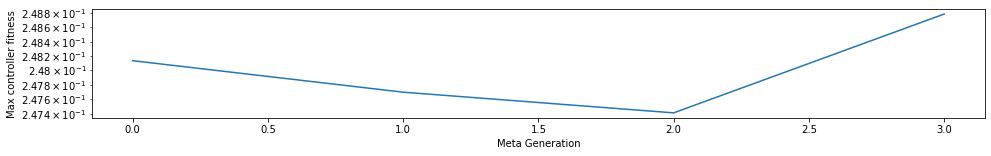

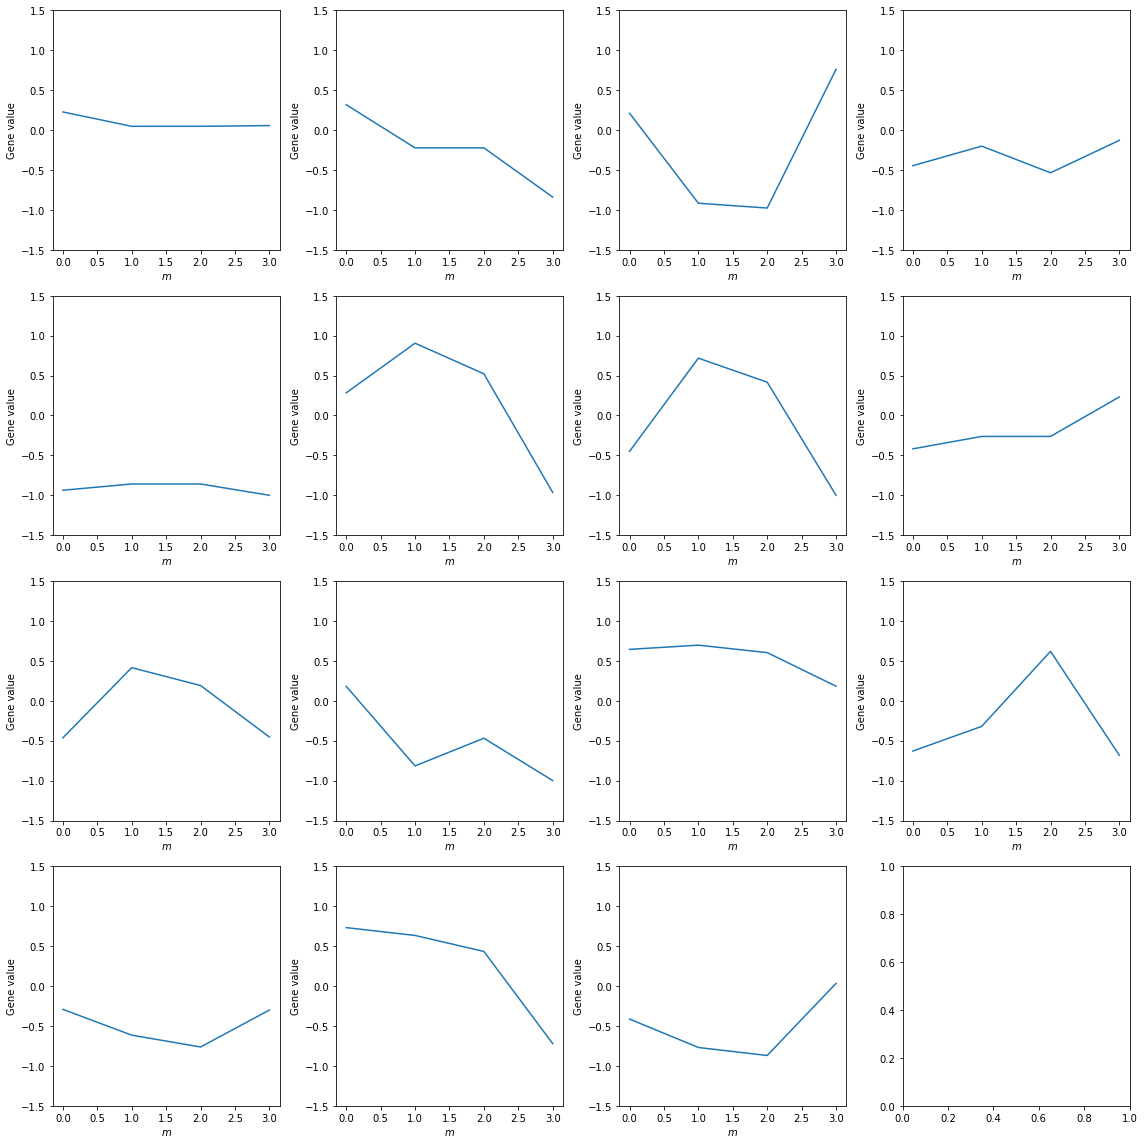

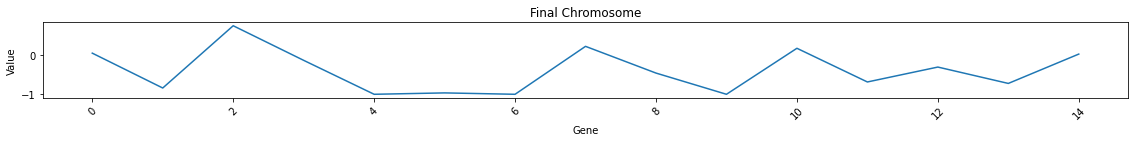

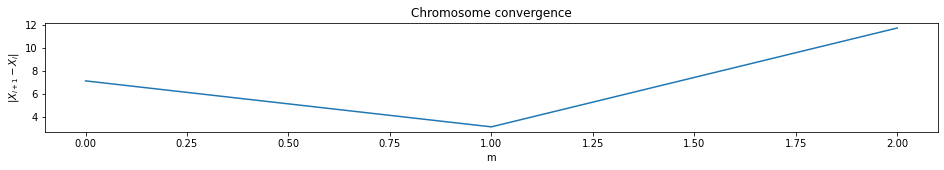

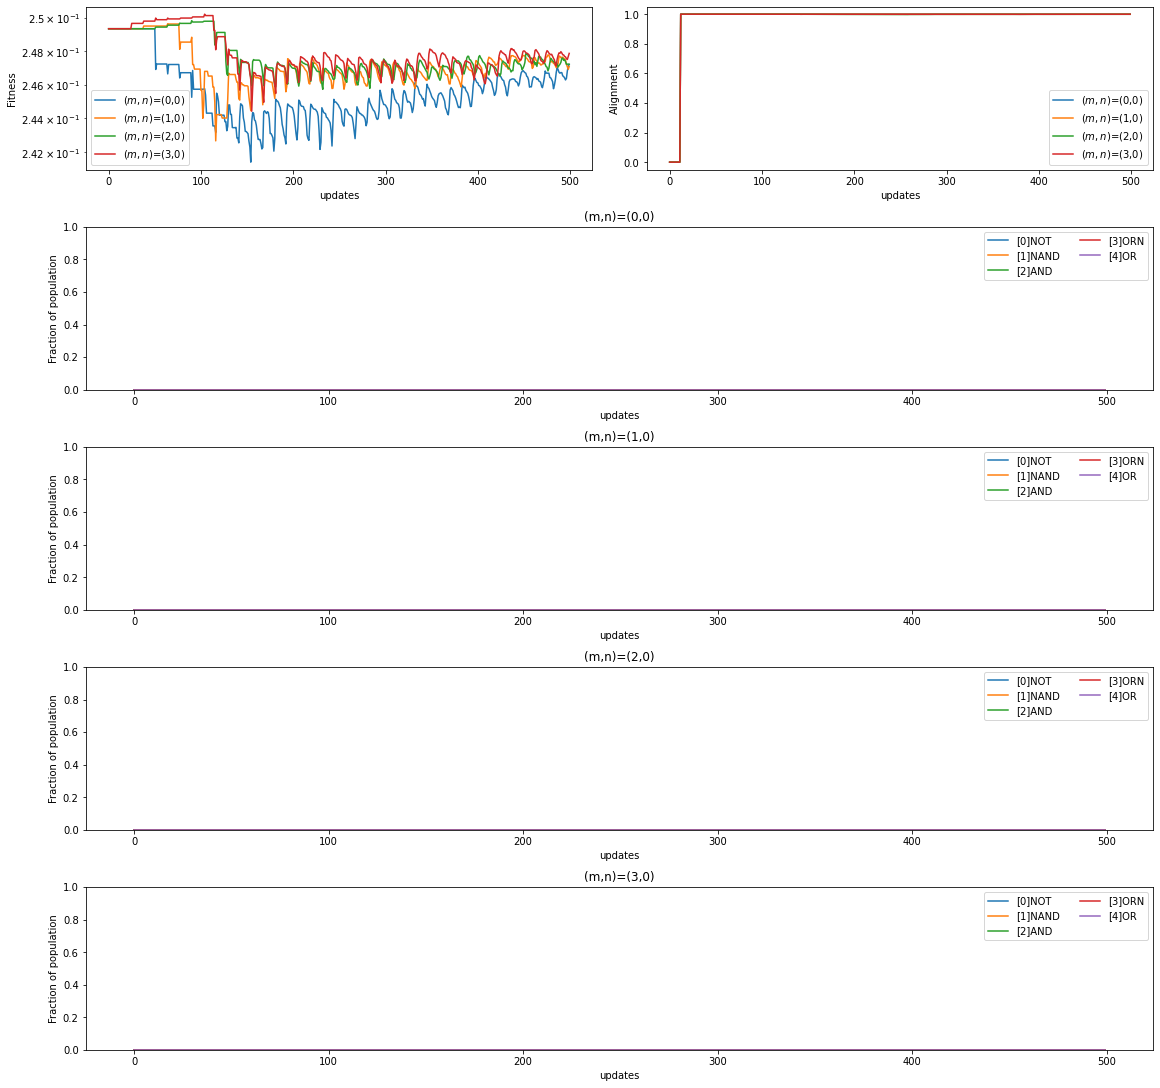

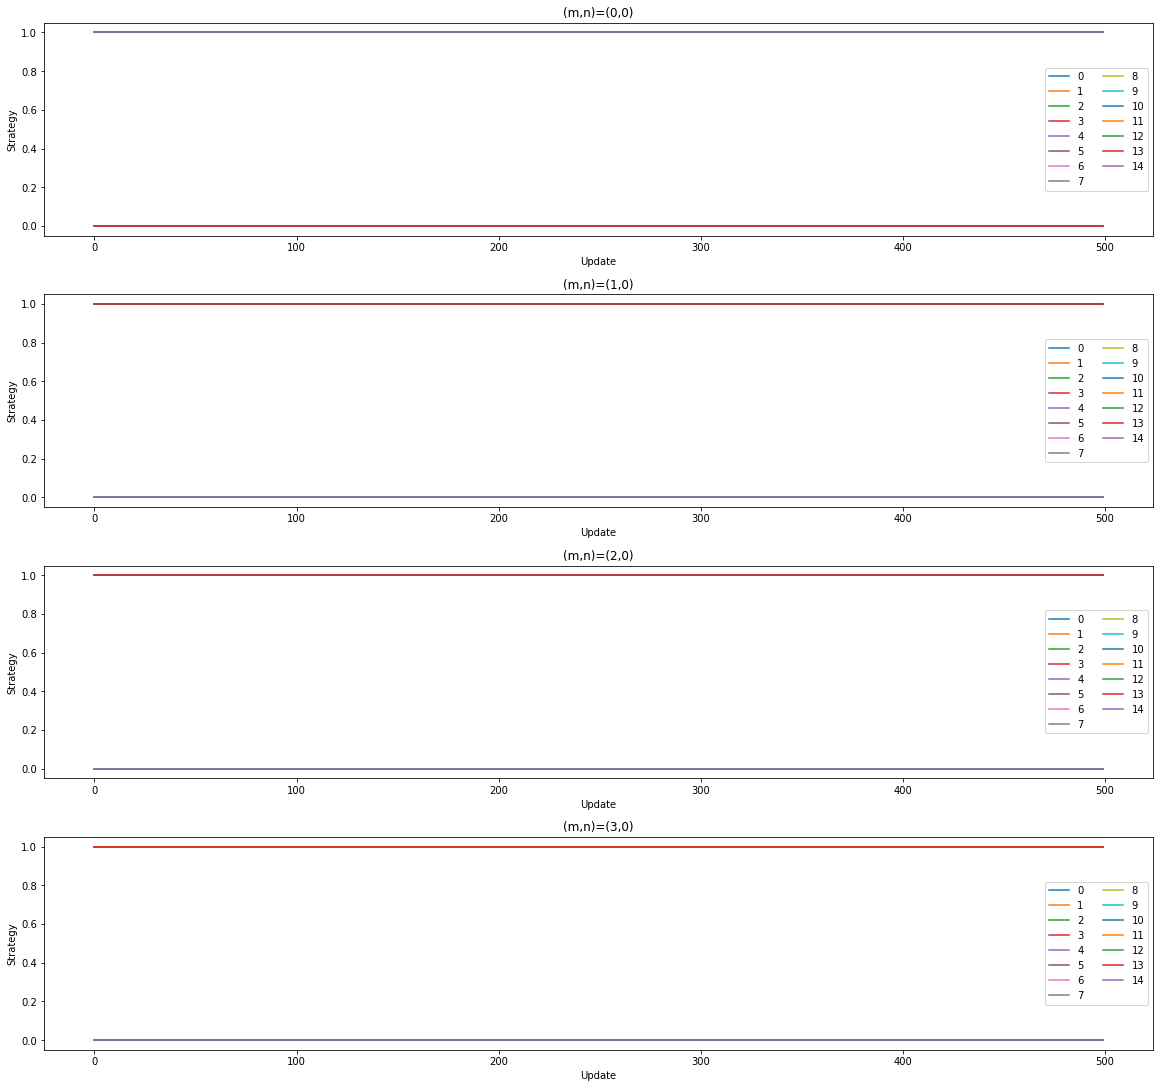

In [25]:
run_name = "cbuild/work/data/AGIdata/run"
M = [i for i in [0,1,2,3]]
N = [0 for i in range(len(M))]

produce_meta_report(run_name=run_name)
compare_meta_runs(M=M, N=N, run_name=run_name) #, save_fig=[True, "tasks_02_25"])
compare_strategies(M=M, N=N, run_name=run_name)

R2 = 1.0
Regression coefficients:
[ 5.27712763e-04  1.97406811e-04 -3.97230851e-04  3.86140031e-06
 -7.20455878e-04  6.34678412e-06  4.09544266e-04  1.13987073e-05
  2.37364386e-04 -3.25686240e-04 -6.06976841e-04  1.83288576e-04
  3.68526330e-04 -3.47882064e-04  8.11846225e-04]


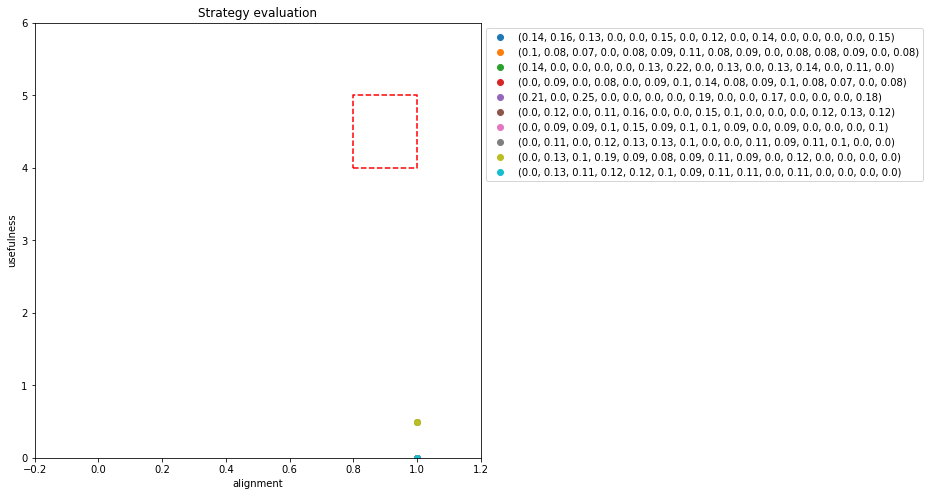

In [26]:


run_name = "cbuild/work/data/AGIdata/run"
strategy_limit = 10
scaling = "prob"
strategy_or_genome = "genome"
produce_strategy_evaluation(run_name, strategy_limit, strategy_or_genome, scaling=scaling)
